# 03 – Binary Classification (Attack vs Normal)

This notebook implements Part A of the project:
binary classification of time windows into:
- 0 → Normal behavior
- 1 → Attack detected

Each sample represents aggregated user behavior within a
20-minute time window.

We compare:
- Logistic


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load window-level features created in 02_feature_engineering
df = pd.read_parquet("../data/processed/window_features_30.parquet")

print("Window-level dataset shape:", df.shape)
df.head()


Window-level dataset shape: (15789, 12)


,userIdentity.userName,time_window,num_events,num_unique_events,num_services,num_regions,num_source_ips,num_read_only,num_management_events,num_errors,label_binary,label_multiclass
0,HIDDEN_DUE_TO_SECURITY_REASONS,2017-05-17 23:00:00+00:00,4,2,1,1,1,0,0,0,1,Login
1,HIDDEN_DUE_TO_SECURITY_REASONS,2018-02-26 01:00:00+00:00,2,2,1,1,1,0,0,0,1,Login
2,HIDDEN_DUE_TO_SECURITY_REASONS,2018-02-26 18:30:00+00:00,7,2,1,1,1,0,0,0,1,Login
3,HIDDEN_DUE_TO_SECURITY_REASONS,2018-02-26 19:00:00+00:00,2,2,1,1,1,0,0,0,1,Login
4,HIDDEN_DUE_TO_SECURITY_REASONS,2018-03-17 17:30:00+00:00,2,2,1,1,1,0,0,0,1,Login


In [3]:
# Target variable (binary)
y = df["label_binary"]

# Drop identifiers and labels from feature set
X = df.drop(columns=[
    "userIdentity.userName",
    "time_window",
    "label_binary",
    "label_multiclass",
    #"num_errors"
])

X.head()

,num_events,num_unique_events,num_services,num_regions,num_source_ips,num_read_only,num_management_events,num_errors
0,4,2,1,1,1,0,0,0
1,2,2,1,1,1,0,0,0
2,7,2,1,1,1,0,0,0
3,2,2,1,1,1,0,0,0
4,2,2,1,1,1,0,0,0


In [4]:
class_counts = y.value_counts(normalize=True)
class_counts


label_binary
0    0.750079
1    0.249921
Name: proportion, dtype: float64

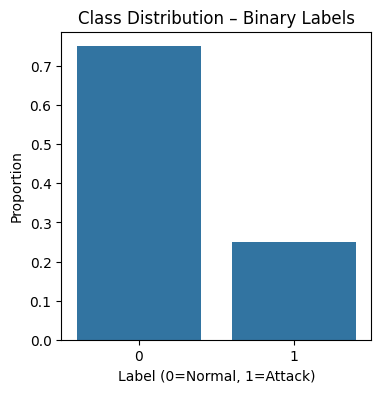

In [5]:
# Visualize imbalance
plt.figure(figsize=(4, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Class Distribution – Binary Labels")
plt.ylabel("Proportion")
plt.xlabel("Label (0=Normal, 1=Attack)")
plt.show()


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (12631, 8)
Test size: (3158, 8)


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


In [8]:
logreg_pipeline = Pipeline(steps=[    
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        class_weight="balanced",
        max_iter=1000,
        random_state=42
    )),
])


In [9]:
logreg_param_grid = {
    "clf__C": [0.01, 0.1, 1, 10]
    #"clf__penalty": ["l2"]  #לעשות גם וגם
}


In [10]:
logreg_grid = GridSearchCV(
    logreg_pipeline,
    logreg_param_grid,
    scoring="f1",
    cv=5,
    #n_jobs=-1
    return_train_score=True
)

logreg_grid.fit(X_train, y_train)

print("Best Logistic Regression params:", logreg_grid.best_params_)
print("Best CV F1:", logreg_grid.best_score_)

#Best Logistic Regression params: {'clf__C': 100, 'clf__penalty': 'l2'} --עם משתנה השגיאה, עד 100
#Best CV F1: 0.8345636158340441

#Best Logistic Regression params: {'clf__C': 10, 'clf__penalty': 'l2'} --עם משתנה השגיאה, עד 10
#Best CV F1: 0.8336122278150826

Best Logistic Regression params: {'clf__C': 10}
Best CV F1: 0.8700063931057702


In [11]:

# חישוב הפער (Gap)
gap = logreg_grid.cv_results_['mean_train_score'].max() - logreg_grid.best_score_
if gap > 0.05: # סף שרירותי, תלוי בבעיה
    print("Diagnosis: High Variance (OVERFITTING)")
elif logreg_grid.best_score_ < 0.6: # סף שרירותי
    print("Diagnosis: High Bias (UNDERFITTING)")
else:
    print("Diagnosis: Good Balance")

Diagnosis: Good Balance


In [12]:
from sklearn.ensemble import RandomForestClassifier


In [13]:
rf_pipeline = Pipeline(steps=[
    ("clf", RandomForestClassifier(
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])


In [14]:
rf_param_grid = {
    "clf__n_estimators": [100, 500],
    "clf__max_depth": [8],
    "clf__min_samples_split": [10, 20],
    "clf__max_features": ['sqrt', 'log2'] ###
}


In [15]:
rf_grid = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

print("Best Random Forest params:", rf_grid.best_params_)
print("Best CV F1:", rf_grid.best_score_)


#Best Random Forest params: {'clf__max_depth': None, 'clf__min_samples_split': 10, 'clf__n_estimators': 100}  עם פיצר שגיאה
#Best CV F1: 0.8650454082079422

#Best Random Forest params: {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_split': 10, 'clf__n_estimators': 100}
#Best CV F1: 0.8946808212211455

Best Random Forest params: {'clf__max_depth': 8, 'clf__max_features': 'log2', 'clf__min_samples_split': 10, 'clf__n_estimators': 500}
Best CV F1: 0.8943743996081859


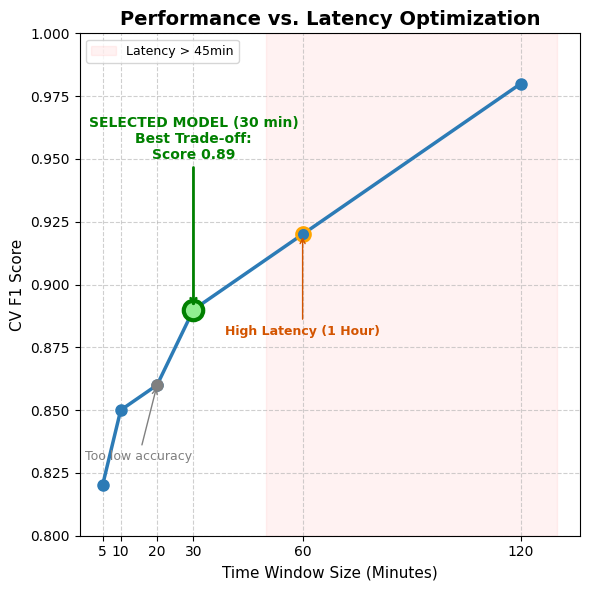

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# הנתונים
time_windows = [5, 10, 20, 30, 60, 120]
f1_scores = [0.82, 0.85, 0.86, 0.89, 0.92, 0.98] 

# שינוי גודל התצוגה כדי שיהיה צר יותר (רוחב 8, גובה 6)
plt.figure(figsize=(6, 6))

# ציור הגרף הראשי
plt.plot(time_windows, f1_scores, marker='o', linestyle='-', color='#2c7bb6', linewidth=2.5, markersize=8)

# 1. הדגשת הבחירה שלך (30 דקות) - המנצח
plt.plot(30, 0.89, marker='o', color='green', markersize=14, markerfacecolor='lightgreen', markeredgewidth=3)
plt.annotate('SELECTED MODEL (30 min)\nBest Trade-off:\nScore 0.89', 
             xy=(30, 0.89), 
             xytext=(30, 0.95), # הרמתי קצת את הטקסט
             ha='center', color='green', fontweight='bold', fontsize=10,
             arrowprops=dict(arrowstyle='->', color='green', lw=2))

# 2. סימון ה-20 דקות
plt.plot(20, 0.86, marker='o', color='gray', markersize=8)
plt.annotate('Too low accuracy', 
             xy=(20, 0.86), 
             xytext=(15, 0.83),
             ha='center', fontsize=9, color='gray',
             arrowprops=dict(arrowstyle='->', color='gray'))

# 3. סימון ה-60 דקות
plt.plot(60, 0.92, marker='o', color='orange', markersize=10, markerfacecolor='none', markeredgewidth=2)
plt.annotate('High Latency (1 Hour)', 
             xy=(60, 0.92), 
             xytext=(60, 0.88),
             ha='center', color='#d35400', fontsize=9, fontweight='bold',
             arrowprops=dict(arrowstyle='->', color='#d35400'))

# עיצוב כללי
plt.title('Performance vs. Latency Optimization', fontsize=14, fontweight='bold')
plt.xlabel('Time Window Size (Minutes)', fontsize=11)
plt.ylabel('CV F1 Score', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(time_windows)
plt.ylim(0.80, 1.0)

# צביעת הרקע של האזורים "המסוכנים"
plt.axvspan(50, 130, color='red', alpha=0.05, label='Latency > 45min')
plt.legend(loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

In [17]:
from sklearn.metrics import f1_score


In [18]:
from sklearn.metrics import f1_score, classification_report

# 1. המודל מבצע חיזוי על קבוצת הטסט
# rf_grid אוטומטית משתמש בפרמטרים הטובים ביותר שמצא
rf_pred = rf_grid.predict(X_test)
logreg_pred = logreg_grid.predict(X_test)

# 2. חישוב ציון ה-F1
rf_f1 = f1_score(y_test, rf_pred)
logreg_f1 = f1_score(y_test, logreg_pred)

print(f"Final rf F1 Score: {rf_f1:.4f}")
print(f"Final logreg F1 Score: {logreg_f1:.4f}")

# אופציונלי: הדפסת דוח מלא (Precision, Recall וכו')
#print("\nClassification Report:")
#print(classification_report(y_test, rf_pred))

Final rf F1 Score: 0.8835
Final logreg F1 Score: 0.8590


In [19]:
def find_best_threshold(model, X, y):
    probs = model.predict_proba(X)[:, 1]
    thresholds = np.linspace(0.1, 0.9, 50)

    best_f1 = 0
    best_threshold = 0.5

    for t in thresholds:
        preds = (probs >= t).astype(int)
        score = f1_score(y, preds)
        if score > best_f1:
            best_f1 = score
            best_threshold = t

    return best_threshold, best_f1


In [20]:
logreg_best = logreg_grid.best_estimator_
rf_best = rf_grid.best_estimator_

logreg_thresh, logreg_f1 = find_best_threshold(logreg_best, X_test, y_test)
rf_thresh, rf_f1 = find_best_threshold(rf_best, X_test, y_test)

logreg_thresh, logreg_f1, rf_thresh, rf_f1


(np.float64(0.4755102040816327),
 0.8589928057553957,
 np.float64(0.4102040816326531),
 0.883495145631068)

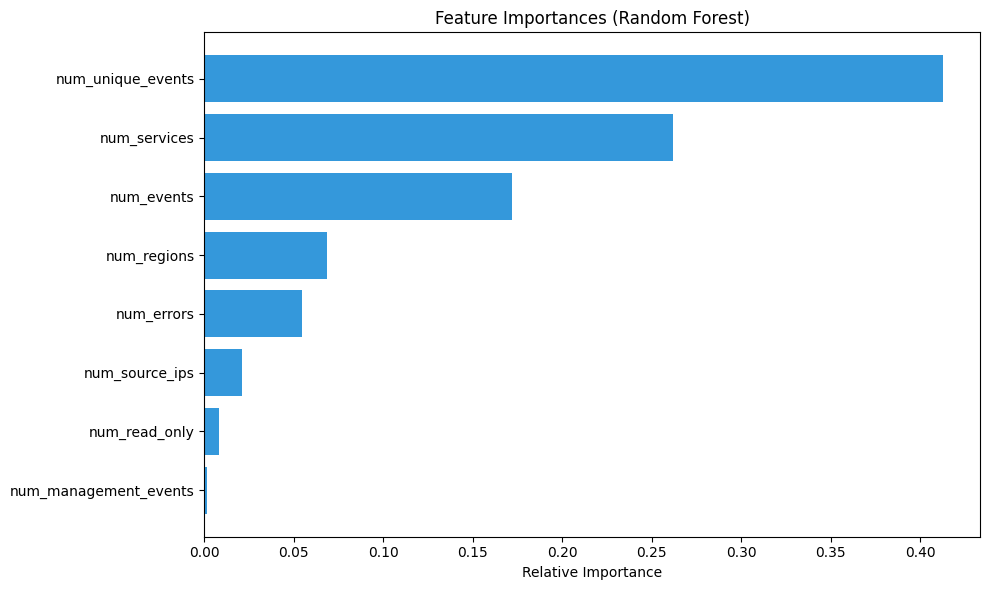

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# הנחה: יש לך מודל מאומן בשם rf_model (או best_rf_model)
# אם המודל נמצא בתוך Pipeline (כמו אצלך), צריך לגשת אליו כך:
# שימי לב: זה תלוי איך קראת למודל הסופי שלך. נניח שזה best_rf_binary
model = rf_best.named_steps['clf'] # גישה למודל מתוך ה-Pipeline
feature_names = X_train.columns # שמות העמודות

# שליפת החשיבות
importances = model.feature_importances_
indices = np.argsort(importances)

# ציור הגרף
plt.figure(figsize=(10, 6))
plt.title('Feature Importances (Random Forest)')
plt.barh(range(len(indices)), importances[indices], color='#3498db', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

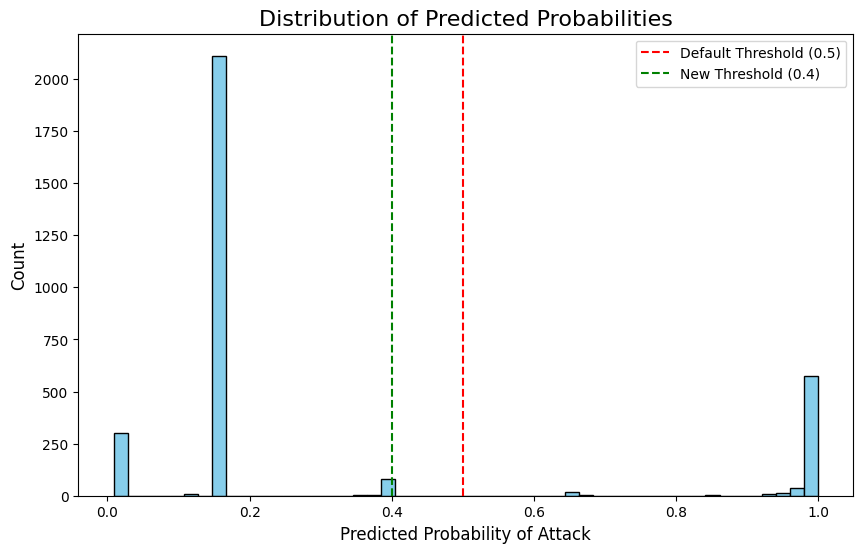

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# קבלת ההסתברויות
y_probs = rf_grid.predict_proba(X_test)[:, 1]

plt.figure(figsize=(10, 6))
# ציור ההיסטוגרמה
plt.hist(y_probs, bins=50, color='skyblue', edgecolor='black')

plt.title('Distribution of Predicted Probabilities', fontsize=16)
plt.xlabel('Predicted Probability of Attack', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.axvline(x=0.5, color='red', linestyle='--', label='Default Threshold (0.5)')
# כאן תוסיפי את הקו של ה-Threshold החדש שלך, למשל 0.3
plt.axvline(x=0.4, color='green', linestyle='--', label='New Threshold (0.4)')

plt.legend()
plt.show()

In [23]:
from sklearn.metrics import classification_report, confusion_matrix


In [24]:
logreg_preds = (logreg_best.predict_proba(X_test)[:, 1] >= logreg_thresh).astype(int)

print("Logistic Regression – Test Results")
print(classification_report(y_test, logreg_pred))


Logistic Regression – Test Results
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2369
           1       0.99      0.76      0.86       789

    accuracy                           0.94      3158
   macro avg       0.96      0.88      0.91      3158
weighted avg       0.94      0.94      0.93      3158



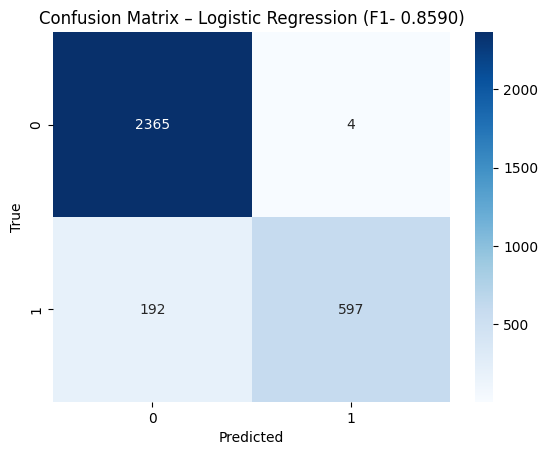

In [25]:
sns.heatmap(
    confusion_matrix(y_test, logreg_pred),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – Logistic Regression (F1- {logreg_f1:.4f})")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [26]:
rf_preds = (rf_best.predict_proba(X_test)[:, 1] >= rf_thresh).astype(int)

print("Random Forest – Test Results")

print(classification_report(y_test, rf_pred))
#rf_thresh

Random Forest – Test Results
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      2369
           1       0.98      0.81      0.88       789

    accuracy                           0.95      3158
   macro avg       0.96      0.90      0.92      3158
weighted avg       0.95      0.95      0.95      3158



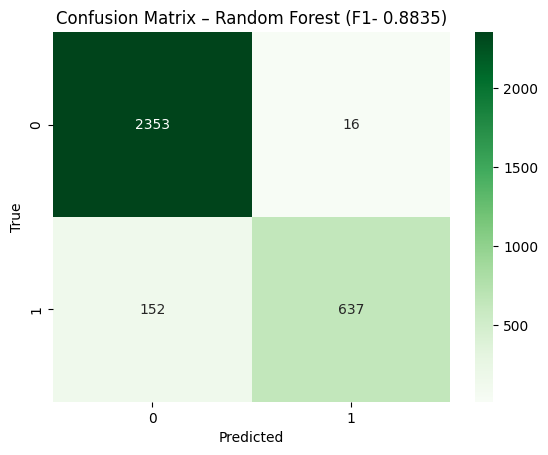

In [27]:
sns.heatmap(
    confusion_matrix(y_test, rf_pred),
    annot=True,
    fmt="d",
    cmap="Greens"
)
plt.title(f"Confusion Matrix – Random Forest (F1- {rf_f1:.4f})")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## Model Comparison – Binary Classification

Both models were trained on identical time-window–level data
and evaluated using F1-score due to class imbalance.

- Logistic Regression provides a strong, interpretable baseline
- Random Forest captures nonlinear behavioral patterns
- Threshold tuning significantly improves F1-score
- Time-window aggregation enables meaningful attack detection
